<a href="https://colab.research.google.com/github/ArifAygun/ML_Calisma_Notebooklari/blob/main/AA_Graduate_Project_2_Silica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

In [184]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
sns.set_theme(color_codes=True)
%matplotlib inline

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

In [185]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation_grouped.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [186]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to  0.17 Mb (50.0% reduction)


##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [187]:
round(flotation.describe(),3).T

,count,mean,std,min,25%,50%,75%,max
iron_feed,4097.0,56.295,5.158,42.740,52.670,56.080,59.720,65.780
silica_feed,4097.0,14.652,6.808,1.310,8.940,13.850,19.600,33.400
starch_flow,4097.0,338.146,92.677,102.567,283.587,335.505,382.469,963.312
amina_flow,4097.0,488.161,83.694,242.927,436.038,502.454,549.522,736.982
pulp_flow,4097.0,397.576,8.370,376.838,398.849,399.841,400.582,418.070
pulp_pH,4097.0,9.768,0.378,8.750,9.541,9.796,10.031,10.810
pulp_density,4097.0,1.680,0.064,1.520,1.651,1.696,1.722,1.833
airflow,4097.0,288.657,18.520,221.602,278.442,299.805,299.976,316.005
level,4097.0,467.252,74.329,340.585,399.869,456.895,514.547,745.230
iron_conc,4097.0,65.050,1.118,62.050,64.370,65.210,65.860,68.010


In [188]:
flotation.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow,level,iron_conc,silica_conc
iron_feed,1.000000,-0.971833,-0.012753,-0.096215,0.186379,0.007458,-0.136404,-0.080216,0.028466,0.055454,-0.077114
silica_feed,-0.971833,1.000000,0.029140,0.085890,-0.174834,0.008383,0.113417,0.107268,-0.049391,-0.044189,0.072782
starch_flow,-0.012753,0.029140,1.000000,0.039488,0.047801,0.230099,-0.118724,0.143422,-0.097972,0.035205,-0.043536
amina_flow,-0.096215,0.085890,0.039488,1.000000,0.237586,0.134163,0.659765,0.131672,-0.324536,-0.120416,0.171142
pulp_flow,0.186379,-0.174834,0.047801,0.237586,1.000000,0.138802,0.019916,-0.181273,-0.030256,0.096595,0.009619
pulp_pH,0.007458,0.008383,0.230099,0.134163,0.138802,1.000000,0.122639,0.182103,-0.121504,0.197962,-0.151422
pulp_density,-0.136404,0.113417,-0.118724,0.659765,0.019916,0.122639,1.000000,-0.023721,-0.148443,0.016802,0.050825
airflow,-0.080216,0.107268,0.143422,0.131672,-0.181273,0.182103,-0.023721,1.000000,-0.461957,0.050338,-0.165113
level,0.028466,-0.049391,-0.097972,-0.324536,-0.030256,-0.121504,-0.148443,-0.461957,1.000000,0.072211,-0.078572
iron_conc,0.055454,-0.044189,0.035205,-0.120416,0.096595,0.197962,0.016802,0.050338,0.072211,1.000000,-0.801212


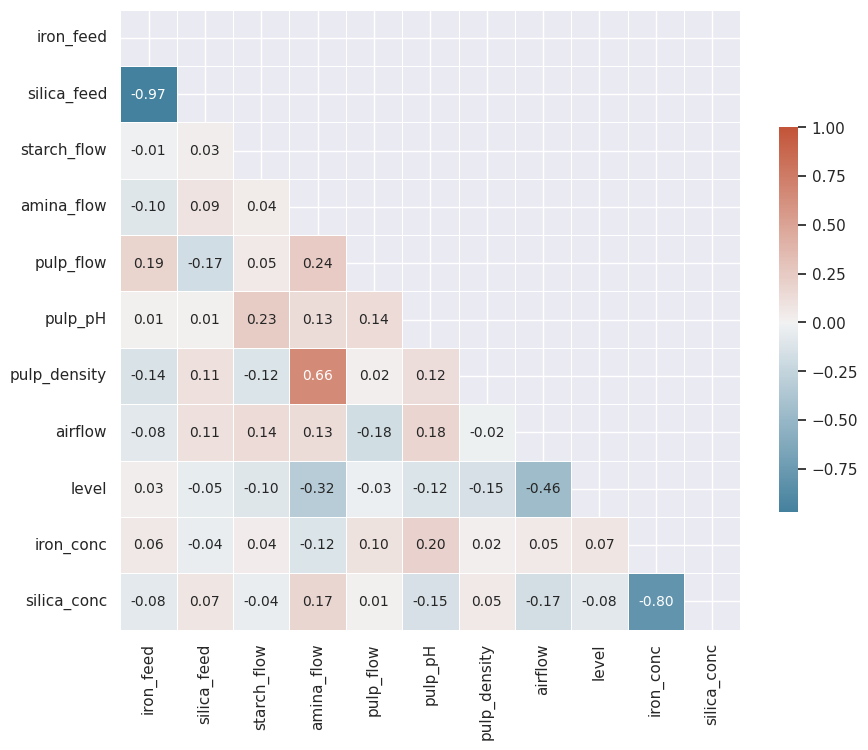

In [189]:
# Correlation Heatmap
f, ax = plt.subplots(figsize=(10, 10))
mat = flotation.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, 
            center=0, annot = True, square=True, 
            linewidths=.5, annot_kws={"fontsize": 10}, 
            cbar_kws={"shrink": .5}, fmt='.2f')
plt.show()

- There is  significant correlation (Pearson = -0.8) between iron concentrate (target_1) and silica concentrate (target_2).
- But there is no significant correlation between target variables and features.

### **5.2. Target Variable (Silica) Statistics**

**Histogram of Silica Concentrate**

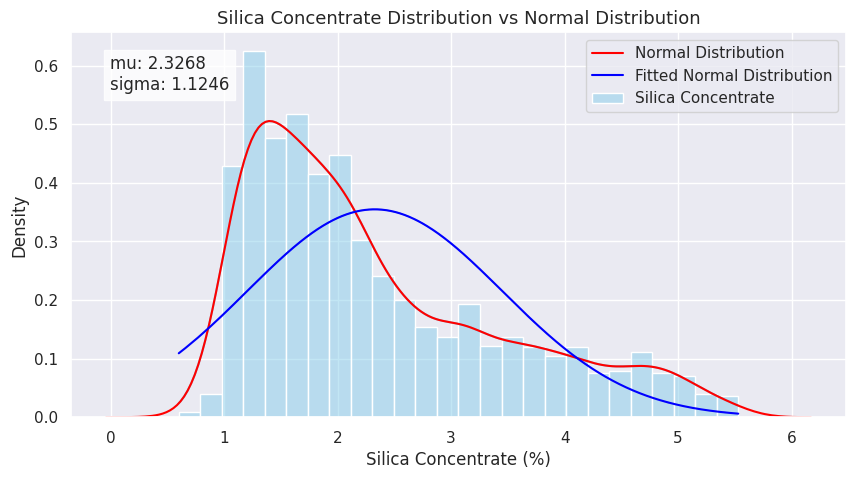

In [190]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(10, 5))
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False,
color='skyblue', label='Silica Concentrate')
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma),
color='blue', label='Fitted Normal Distribution')

plt.text(0.05, 0.85, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.title('Silica Concentrate Distribution vs Normal Distribution', fontsize=13)
plt.xlabel("Silica Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.show()

- mu = 2.3268 indicates that, on average, the Silica Concentrate percentage is around 2.33%. 
- sigma = The standard deviation of 1.1246 suggests that the data points are dispersed around the mean, with a typical deviation of approximately 0.11%.

- The histogram and KDE plot show the distribution of the actual data, while the red curve represents the fitted normal distribution.
- The blue line represents the line plot of the fitted normal distribution, providing a visual representation of how well the normal distribution fits the data.

**Skewness and Kurtosis**

In [191]:
t,p = stats.shapiro(flotation['silica_conc'])

print("Skewness: %f" % abs(flotation['silica_conc']).skew())
print("Kurtosis: %f" % abs(flotation['silica_conc']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: 0.967455
Kurtosis: -0.015312
Shapiro_Test of t: 0.894797
Shapiro_Test of p: 0.000000


- The skewness of 0.967455 indicates that the distribution of the silica concentrate data is positively skewed. This means that the tail of the distribution is skewed towards higher values, and the majority of the data points are concentrated towards the lower end.

- The kurtosis of -0.015312 suggests that the distribution of the silica concentrate data has slightly lower kurtosis than a normal distribution. Negative kurtosis indicates that the distribution has lighter tails and is less peaked compared to a normal distribution. However, the kurtosis value is close to zero, suggesting that the data is approximately normally distributed in terms of its shape.

- The Shapiro-Wilk test of normality resulted in a test statistic of 0.894797 and a p-value of 0.000000. The low p-value indicates that the data significantly deviates from a normal distribution. In other words, the silica concentrate data is not normally distributed.

- The silica concentrate data exhibits positive skewness and slightly lower kurtosis. It departs from a normal distribution, as indicated by the Shapiro-Wilk test. These characteristics should be considered when analyzing the data and choosing appropriate statistical methods or models.

**Fitting the distribution of Silica Concentrate**

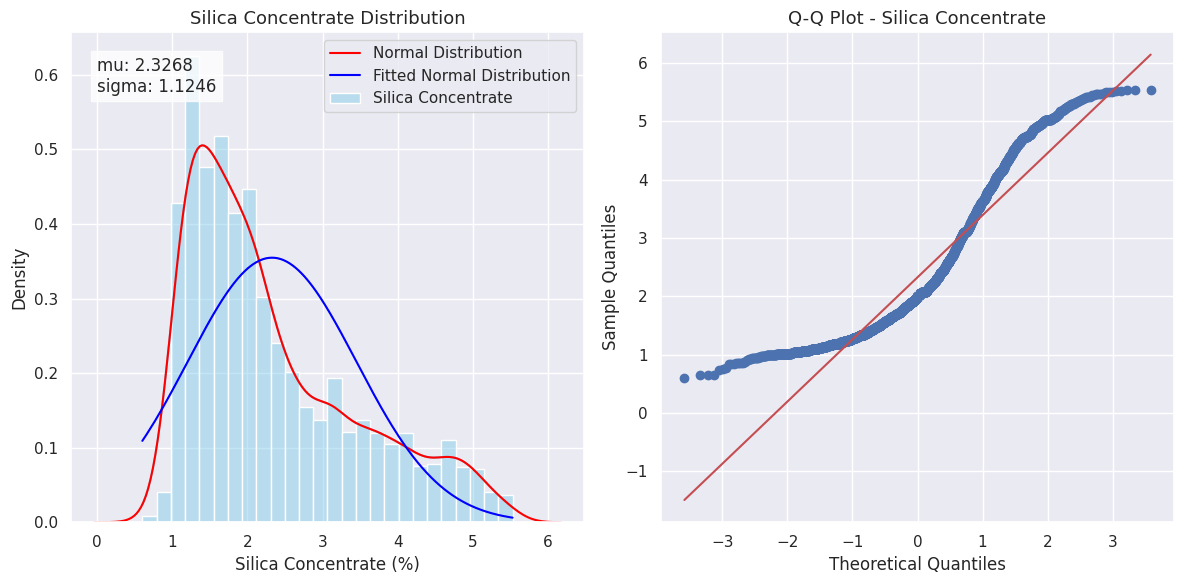

In [193]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['silica_conc'], kde=True, stat="density", common_norm=False, 
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(flotation['silica_conc'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['silica_conc'], y=norm.pdf(flotation['silica_conc'], mu, sigma), 
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.05, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8))

axes[0].set_title('Silica Concentrate Distribution', fontsize=13)
axes[0].set_xlabel("Silica Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend()

# Q-Q plot
stats.probplot(flotation['silica_conc'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Silica Concentrate", fontsize=13)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout()
plt.show()

Now let's try to tranform our silica concentration distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see the transformation effect.

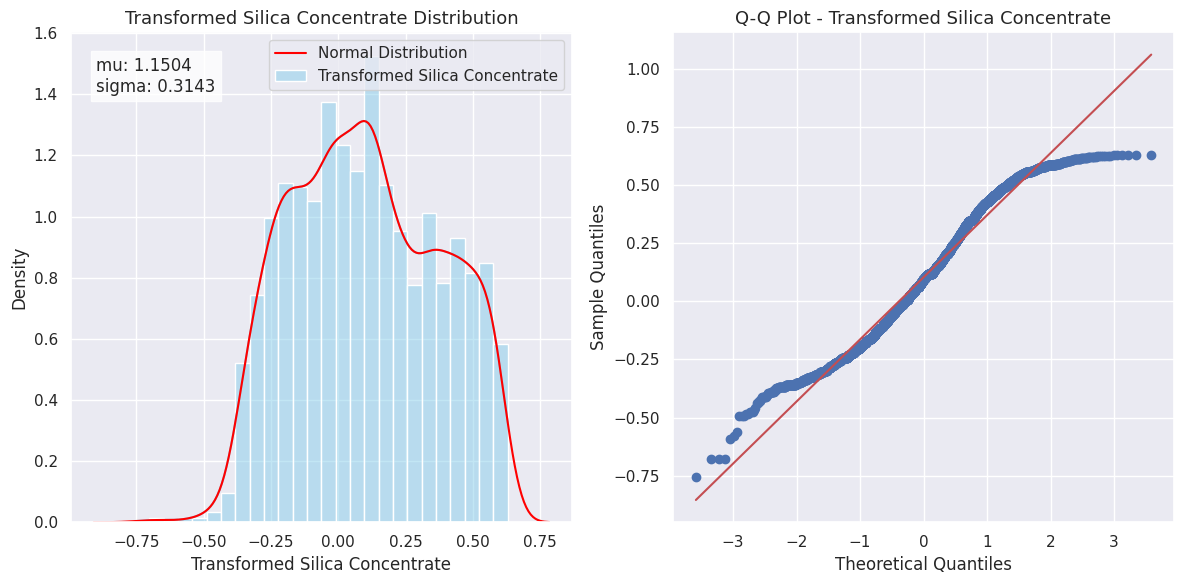

In [206]:
# Log transformation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['silica_conc'])

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram, KDE, and fitted normal distribution
sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False,
color='skyblue', label='Transformed Silica Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Silica Concentrate Distribution', fontsize=13)
axes[0].set_xlabel("Transformed Silica Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend()


axes[0].text(0.05, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8))


# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Silica Concentrate", fontsize=13)
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout()
plt.show()

- In the histogram and KDE plot of the transformed silica concentrate, the distribution appears to be more symmetric and closer to a normal distribution compared to the original data. The log transformation helps reduce the positive skewness and makes the data more evenly distributed.

- The Q-Q plot of the transformed data shows that the points follow a relatively straight line, indicating a closer fit to the theoretical quantiles of a normal distribution. This further supports the assumption of approximate normality after the transformation.

**Silica Concentrate vs Iron Concentrate**

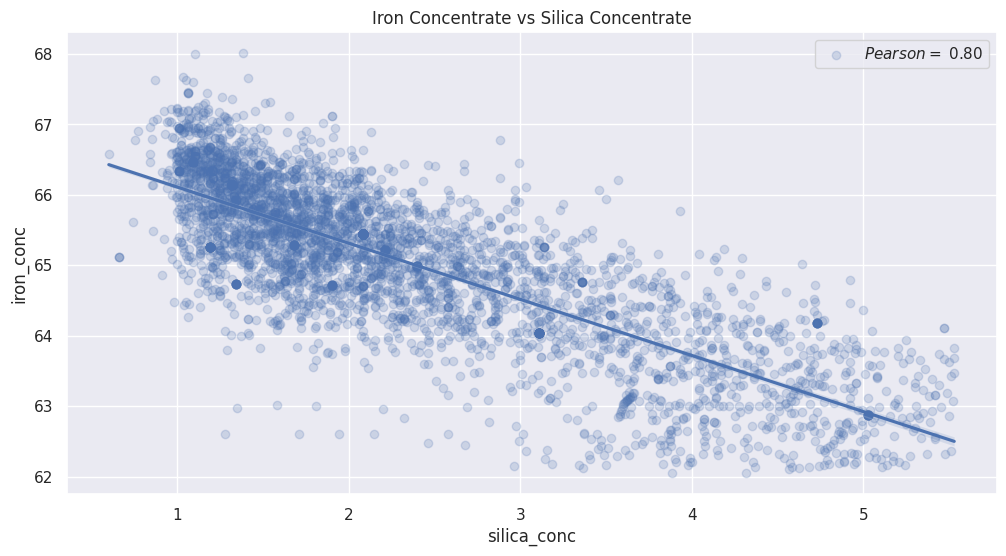

In [195]:
# iron concentrate (target_1) and silica concentrate (target_2) [Pearson = 0.8]

Pearson = 0.80
plt.figure(figsize = (12,6))
sns.regplot(data=flotation, x = 'silica_conc', y='iron_conc', scatter_kws={'alpha':0.2})
plt.title('Iron Concentrate vs Silica Concentrate', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

- There is a reverse linear relationship between Iron and Silica Concetrates

## **6. Machine Learning**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [197]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)
print("Shape of y_Fe:", y_Fe.shape)

Shape of X: (4097, 9)
Shape of y_Si: (4097,)
Shape of y_Fe: (4097,)


### **6.2. Performance Predicting of Silica Concentrate**

**Split (train, validation, test)**

In [198]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**MSE - MAE - R^2**

               Model       MSE       MAE       R^2
1      Random Forest  0.065296  0.208642  0.330605
2            XGBoost  0.070370  0.208861  0.278585
4                SVM  0.084926  0.234520  0.129367
3           AdaBoost  0.085268  0.247757  0.125854
0  Linear Regression  0.090152  0.245840  0.075785
5         ElasticNet  0.098420  0.256949 -0.008974
6      Decision Tree  0.149188  0.292357 -0.529434


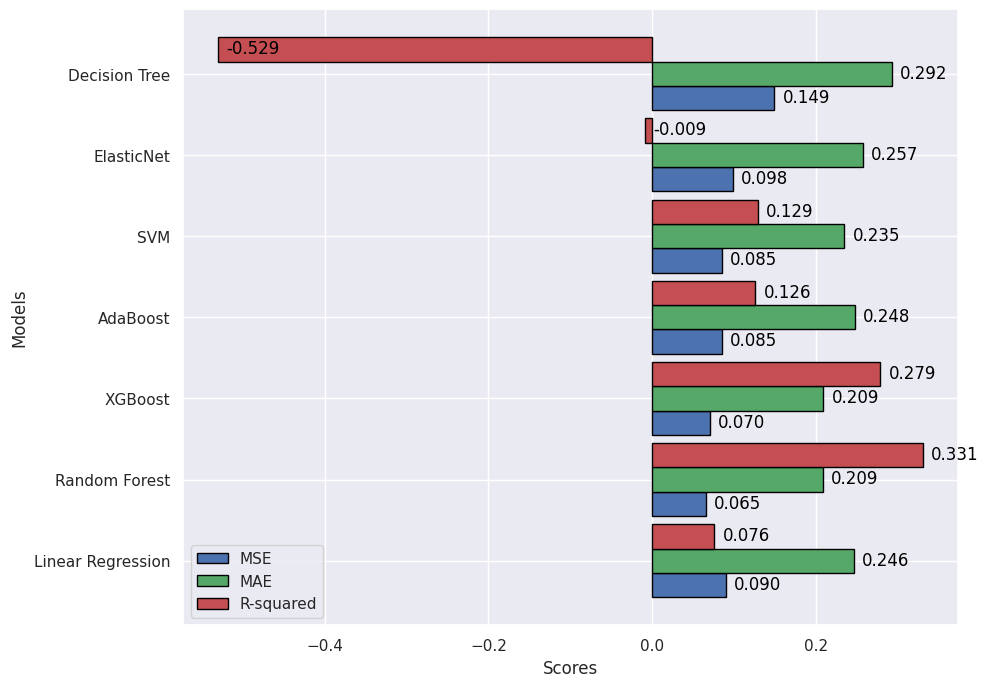

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'),
          (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]

# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the validation data
    val_pred = pipeline.predict(X_val)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Write the evaluation metric scores
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores})
scores_df = scores_df.sort_values(by='MSE', ascending=True)
print(scores_df)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 8))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='lower left')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', color='black')
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', color='black')
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', color='black')

plt.show()

- Random Forest: This model has the lowest MSE and highest R^2 score, indicating better overall performance compared to the other models. It also has a relatively low MAE, suggesting good accuracy in predicting the target variable.

- XGBoost: This model performs well with a relatively low MSE and MAE. Although its R^2 score is lower than Random Forest, it still indicates a reasonable level of prediction capability.

- SVM: The Support Vector Machine (SVM) model has a higher MSE, MAE, and lower R^2 compared to the previous models. It may not perform as well as Random Forest and XGBoost in this scenario.

- AdaBoost: The AdaBoost model shows higher MSE, MAE, and lower R^2 compared to the previous models, suggesting relatively poorer performance in predicting the target variable.

- Linear Regression: The simple Linear Regression model performs worse than the ensemble-based models. It has a higher MSE, MAE, and lower R^2, indicating limitations in capturing the complexity of the data.

- ElasticNet: The ElasticNet model performs worse than the linear regression model, as evident from its higher MSE, MAE, and negative R^2 score. It may not be the best choice for this particular dataset.

- Decision Tree: The Decision Tree model has the highest MSE and MAE and the most negative R^2 score. It seems to struggle in capturing the underlying patterns in the data and producing accurate predictions.

- Finally, **the ensemble-based models (Random Forest and XGBoost) perform better than the other models for iron concentrate**. The SVM model also shows some potential but is outperformed by the ensemble models. The linear regression, AdaBoost, ElasticNet, and Decision Tree models exhibit poorer performance.

In [200]:
# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### **7. Modeling**

In [201]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [202]:
import shap
import xgboost as xgb
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [203]:
# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### **7.1. Modelling for Silica Concentrate**

#**Iron Concentrate**

**Split (train, validation, test)**

In [204]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Fe, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**MSE - MAE - R^2**

               Model       MSE       MAE       R^2
1      Random Forest  0.788171  0.692714  0.316679
2            XGBoost  0.836441  0.716634  0.274830
4                SVM  1.013465  0.788963  0.121356
3           AdaBoost  1.034911  0.834317  0.102763
0  Linear Regression  1.048382  0.820273  0.091084
5         ElasticNet  1.153373  0.851374  0.000060
6      Decision Tree  1.806444  0.986089 -0.566134


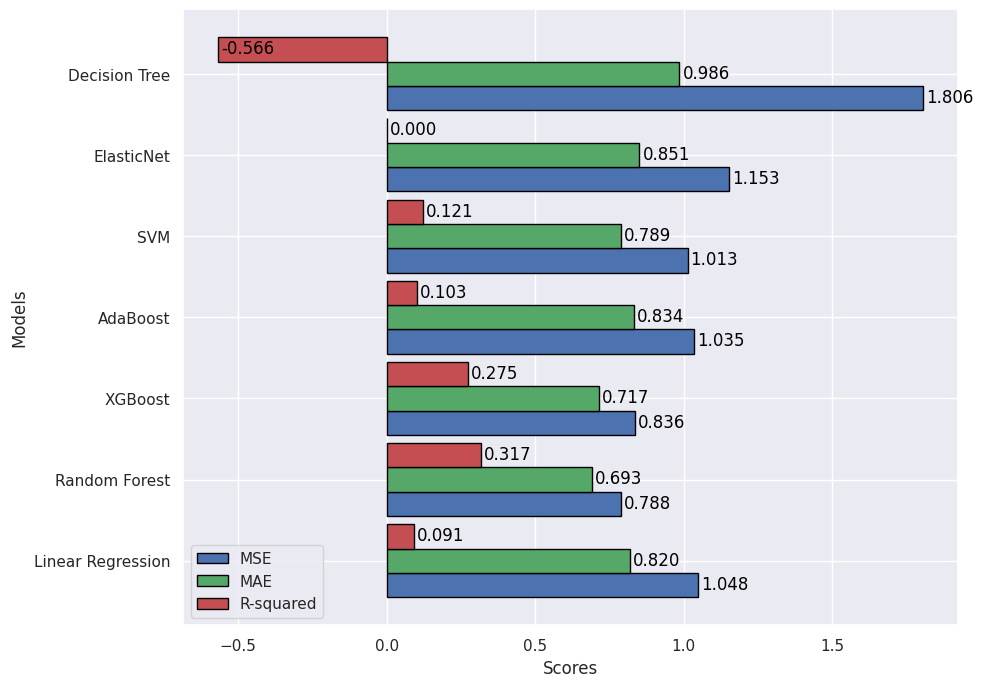

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'),
          (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]

# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the validation data
    val_pred = pipeline.predict(X_val)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Write the evaluation metric scores
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores})
scores_df = scores_df.sort_values(by='MSE', ascending=True)
print(scores_df)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 8))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='lower left')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', color='black')
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', color='black')
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', color='black')

plt.show()